In [1]:
%matplotlib notebook
import cmath
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from indra.common import Circle, Line
from indra.mobius import MobiusTransformation as Mobius
from indra.plotting.tiles import plot_tiles
from indra.plotting.limit import plot_limit_set
from indra.recipes import kissing_schottky

In [14]:
# Apollonian gasket generators
a = Mobius(1, 0, -2j, 1)
b = Mobius(1-1j, 1, 1, 1+1j)
A = a.inv()
B = b.inv()

gens = [a, b, A, B]

In [3]:
# Figure out what C_b is from tangency points
z1 = complex(1, 0)
z2 = complex(0, -1)
z3 = complex(0.2, -0.4)

w = z3 - z1
w /= z2 - z1
cen = (z1 - z2) * (w - abs(w) ** 2) / 2j / w.imag - z1
rad = abs(cen + z1)

In [4]:
-cen, rad

((0.9999999999999999-0.9999999999999999j), 0.9999999999999999)

In [5]:
C_a = Line(np.pi/2, 0)
C_A = A(C_a)
C_b = Circle(complex(1, -1), 1)
C_B = Circle(complex(-1, -1), 1)

circs = [C_a, C_b, C_A, C_B]

<IPython.core.display.Javascript object>


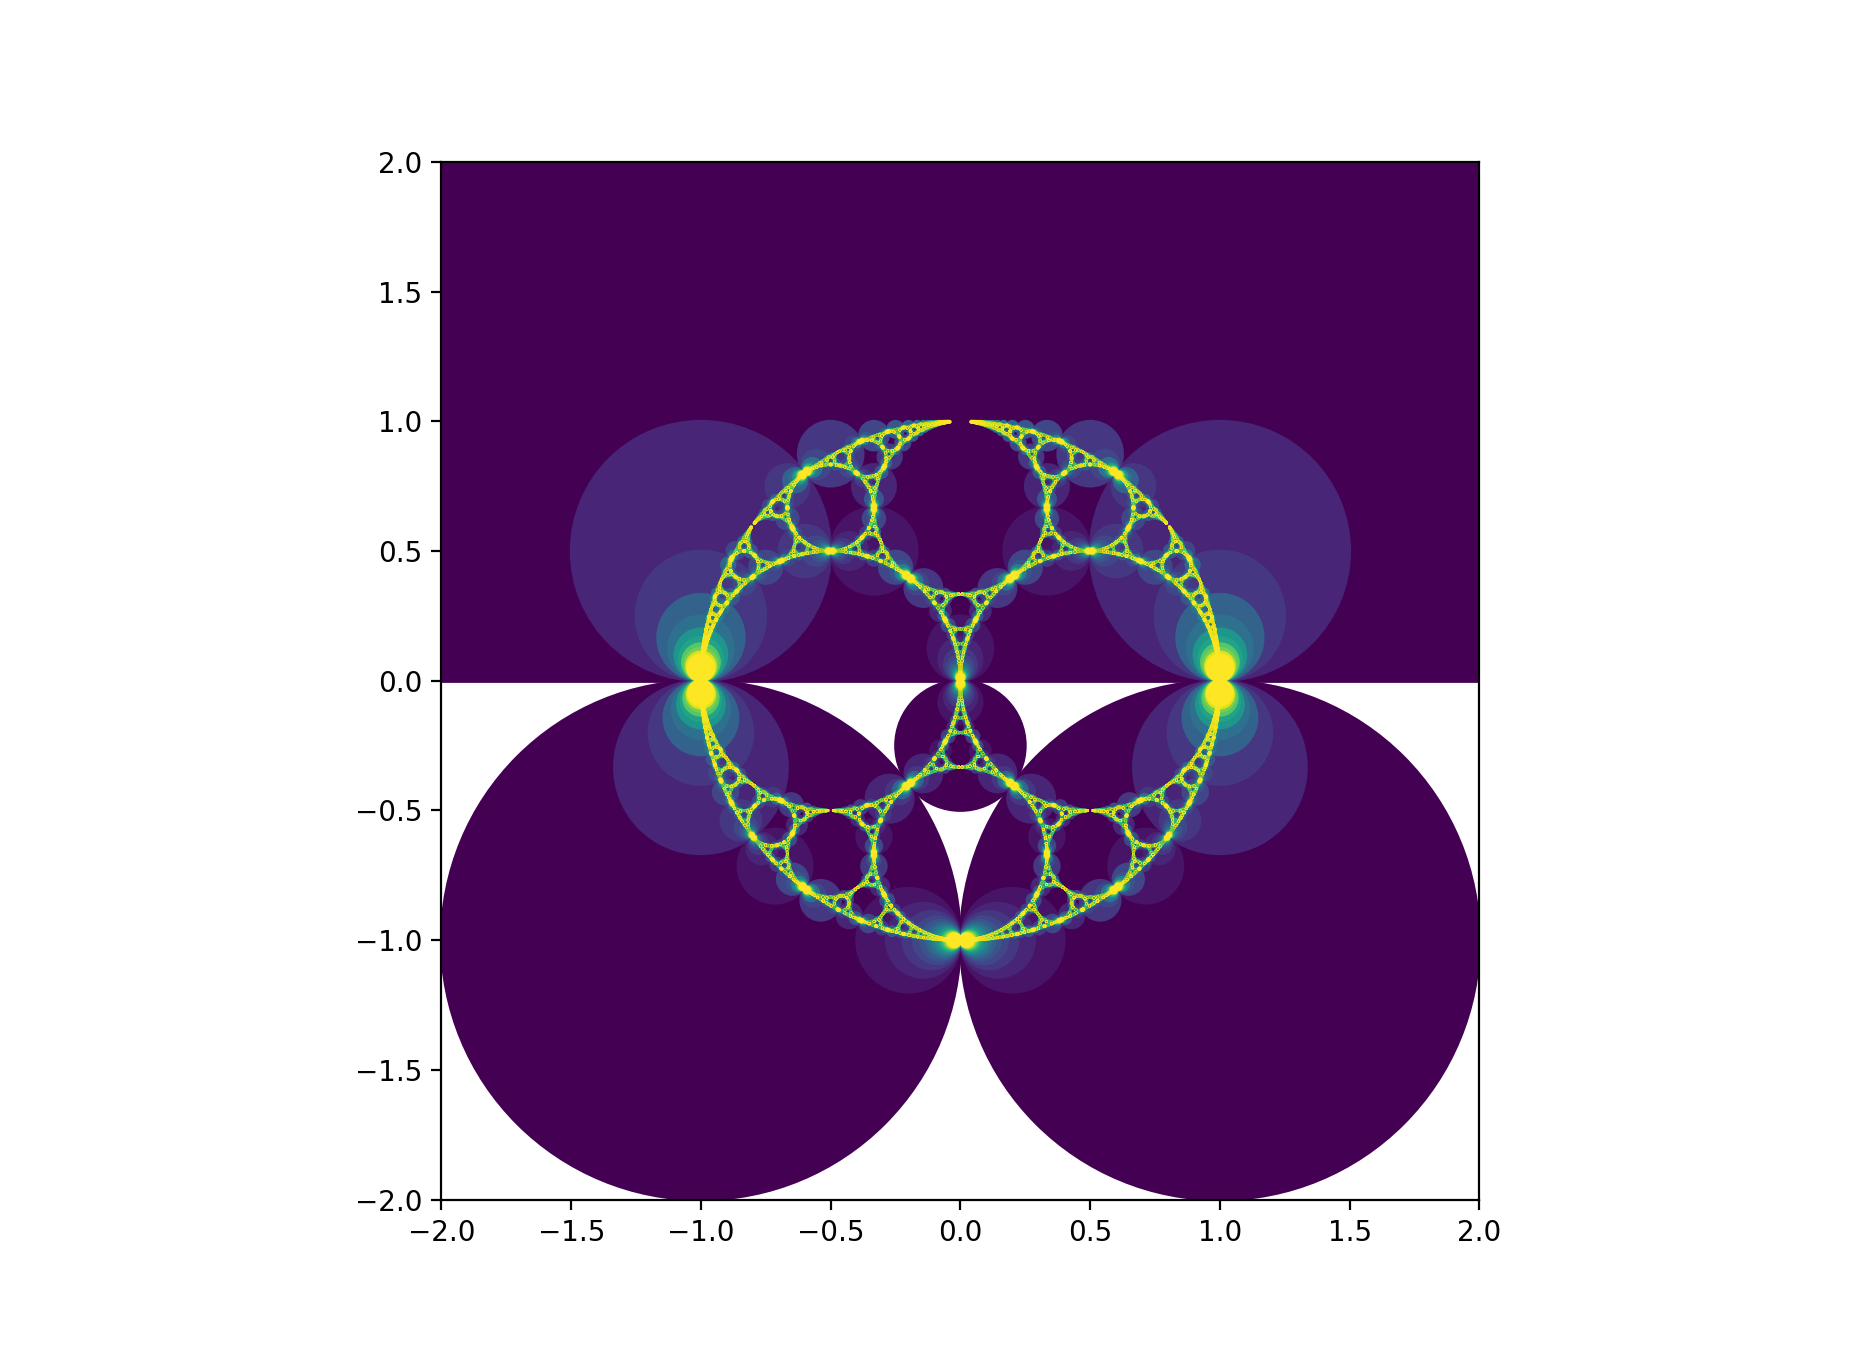

/Users/april/projects/indra/venv/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5293: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = start
/Users/april/projects/indra/venv/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5294: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 1] = end
/Users/april/projects/indra/venv/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5299: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 2:, 1] = y2slice[::-1]
/Users/april/projects/indra/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

plot_tiles(gens, circs, plot_level=25, ax=ax)

<IPython.core.display.Javascript object>


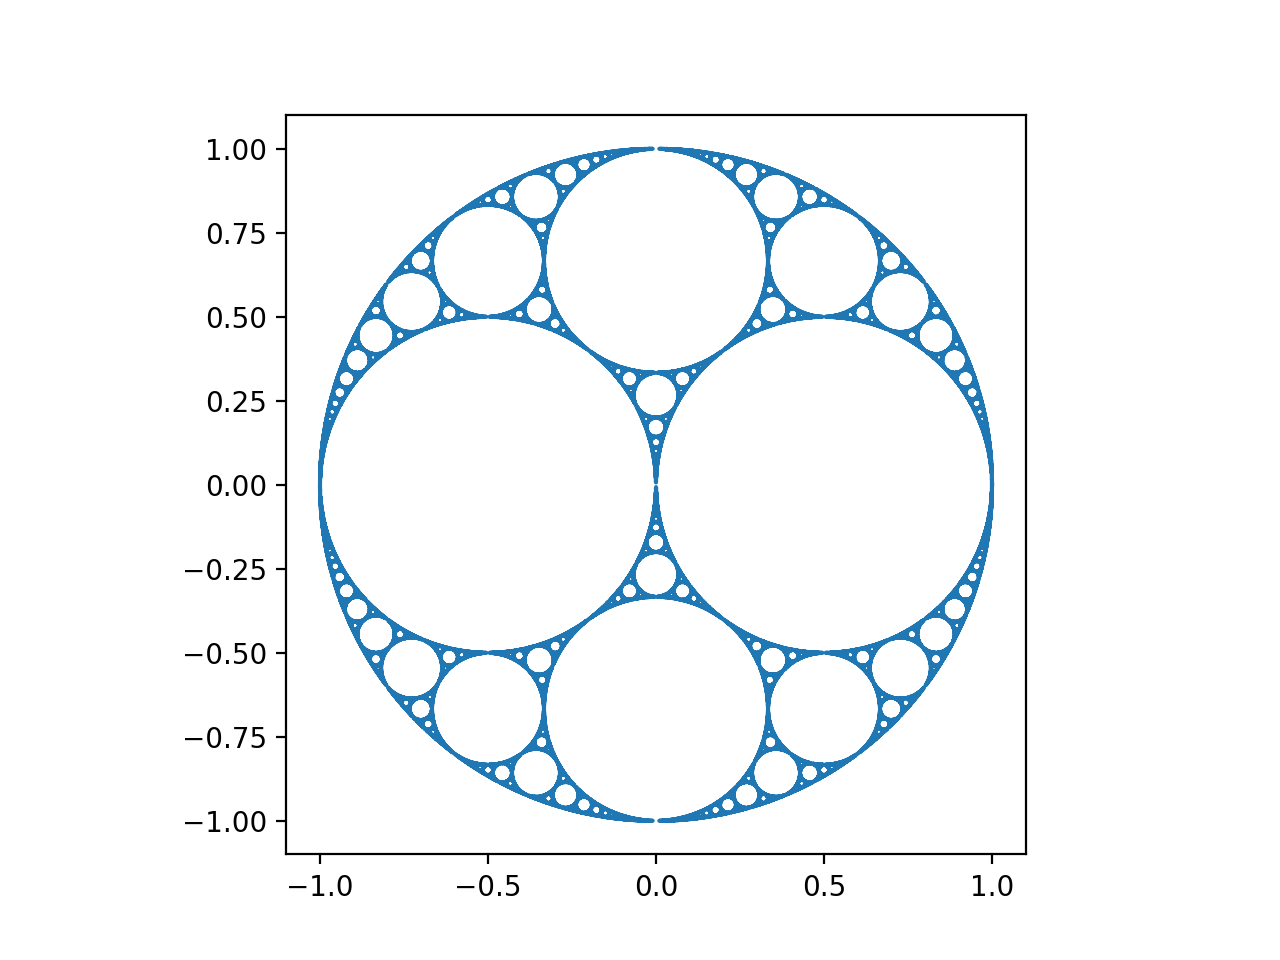

In [3]:
plot_limit_set(gens)

## The problem of gaps

In [3]:
char_to_tag = {'a': 0, 'b': 1, 'A': 2, 'B': 3}
tag_to_char = ['a', 'b', 'A', 'B']

def tags_to_word(tags):
    return ''.join(tag_to_char[t] for t in tags)

def word_to_fct(s, gens):
    return reduce(lambda S, T: S(T), (gens[char_to_tag[c]] for c in s))

def tags_to_fct(tags, gens):
    return reduce(lambda S, T: S(T), (gens[t] for t in tags))

In [4]:
def get_gasket_fps(gens):
    # repetends[i] is a list of words corresponding to repetends to be considered for a word ending in tag i
    # TODO: this is specific to the generators,
    # we should be able to compute them automatically or get the recipes to return them.
    # In general, we need to track parabolic (or nearly parabolic) words and their cyclic permutations
    # that end with the tag in question.
    repetends = [
        ['bABa', 'a', 'BAba'],
        ['ABab', 'b', 'aBAb'],
        ['BabA', 'A', 'baBA'],
        ['abAB', 'B', 'AbaB']
    ]
    repetends = [
        [word_to_fct(s, gens) for s in l]
        for l in repetends
    ]
    return [
        [T.sink() for T in l]
        for l in repetends
    ]

In [5]:
from indra.plotting.limit import *

In [42]:
def special_dfs(gens, max_level=MAX_LEVEL, eps=VISUAL_EPS, debug=False):
    """
    Non-recursive DFS for plotting limit set (only for 4 generators).
    Modified for special words.

    :param gens: list of generating Mobius transformations
    :param max_level: max level to plot
    :param eps: tolerance for termination
    :param debug: debug prints
    :return: complex points to plot
    """
    tags = deque([0])
    words = deque([gens[0]])
    fps = get_gasket_fps(gens)  # diff

    level = 1

    while True:
        # go forwards till the end of the branch
        while True:
            new_pts = special_branch_termination(words[-1], fps[tags[-1]], eps, level, max_level)  # diff
            if len(new_pts) > 0:
                break
            next_tag = right_of(tags[-1])
            next_word = words[-1](gens[next_tag])
            tags.append(next_tag)
            words.append(next_word)
            level += 1

        # we have a result!
        yield from new_pts  # diff
        if debug:
            print(level)
            print_current_word(tags)

        # go backwards till we have another turn or reach the root
        while True:
            last_tag = tags.pop()
            _ = words.pop()
            level -= 1
            if level == 0 or available_turn(last_tag, tags[-1]):
                break

        # turn and go forwards
        next_tag = left_of(last_tag)
        if level == 0:
            # if we're back to the first generator at the root, we're done!
            if next_tag == 0:
                break
            next_word = gens[next_tag]
        else:
            next_word = words[-1](gens[next_tag])
        tags.append(next_tag)
        words.append(next_word)
        level += 1


def special_branch_termination(T, fps, eps, level, max_level):
    """Return points to plot if we should terminate branch, or empty list"""
    zs = [T(fp) for fp in fps]    
    if level > max_level or all(abs(zs[i+1] - zs[i]) < eps for i in range(len(zs)-1)):
        return zs
    return []  # nothing new to plot, keep going

<IPython.core.display.Javascript object>


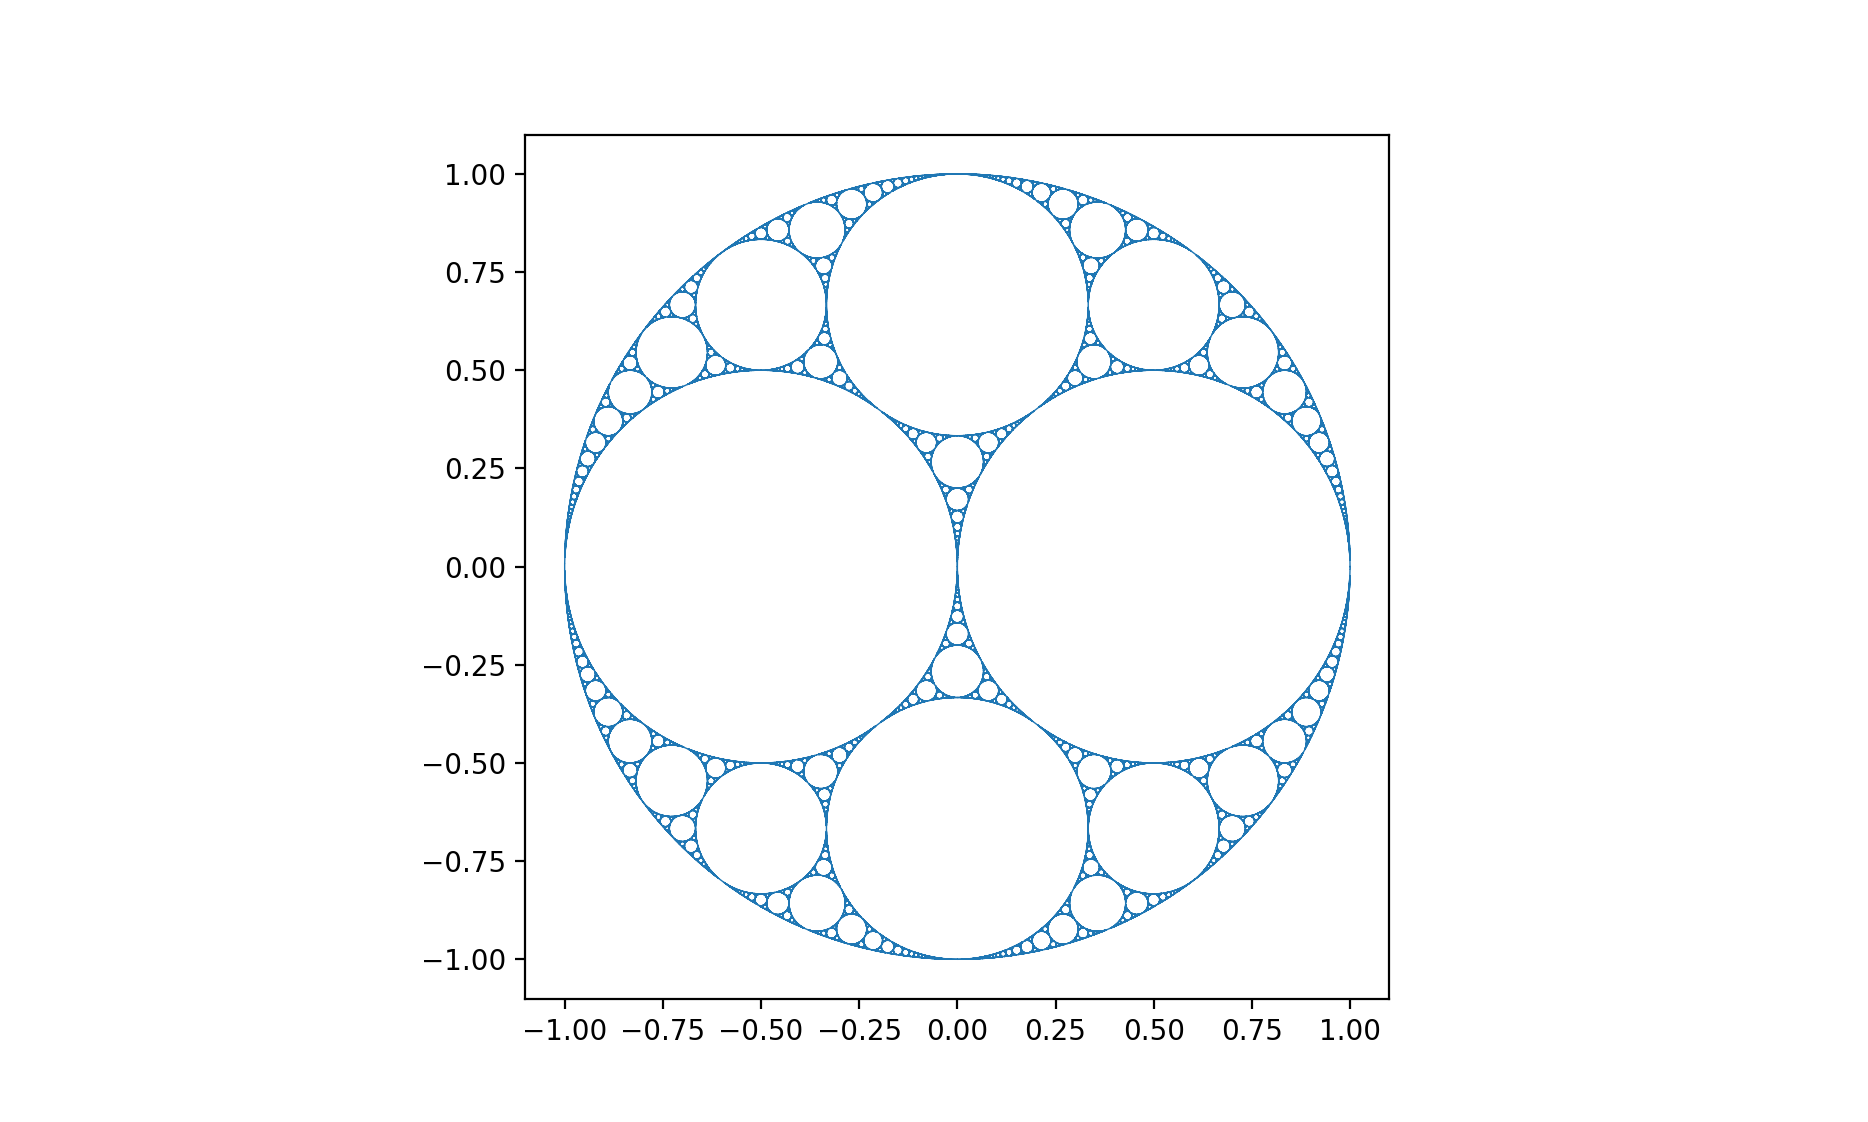

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
pts = list(special_dfs(gens))
ax.plot([x.real for x in pts] + [pts[0].real], [x.imag for x in pts] + [pts[0].imag], linewidth=0.5)